# Treinando RandomForest

In [70]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
import csv
import unidecode 
import pandas.core.algorithms as algos
from scipy.stats import kendalltau   
from funcoes_uteis import *
from dateutil.relativedelta import relativedelta

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [71]:
def diff_month(d1, d2):
    return (d1.year - d2.year)*12 + d1.month - d2.month

def periodicidade(x):
    if x == 'Trienal':
        return 36    
    elif x == 'Anual':
        return 12
    elif x == 'Semestral':
        return 6
    elif x == 'Trimestral':
        return 3
    else: 
        return 1

def marca_base(Perc, x):
    if x >= Perc[(len(Perc)-1)]:
        return len(Perc) +1
    else:
        for i in range(len(Perc)):
            if x < Perc[i]:
                return i + 1


def cria_curva(percentiles, variavel):
    Perc = list()
    for i in range(len(percentiles)):
        Perc.append(np.percentile(variavel, percentiles[i]))
    return Perc    
    


In [72]:
df_base = pd.read_csv('./Churn_Consumo_Recomendacao_17.07.2017.csv'
                      , error_bad_lines = False
                      , sep=';'
                      , dtype= {7: str}
                      , encoding='latin-1'
                      , header = None)

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
s = ['Provisioning', 'cd_ChaveCliente', 'nr_PrecoMensal', 'ds_Periodicidade', 'Instalacao', 
     'Primeiro_Servico_LW', 'dt_Reativacao', 'fl_ServicoPai', 'id_GerenteConta', 'Servico', 
     'fl_Dev', 'Perfil', 'classificacao', 'Status', 'Data_Fim', 'Data_Desativacao']

df_base.columns = s

In [74]:
col_datas = ['Data_Desativacao', 'Data_Fim', 'Instalacao', 'dt_Reativacao', 'Primeiro_Servico_LW']
converte_datetime(df_base, col_datas)

In [75]:
df_base['Status'] = ['ativo' if s in ['Ativo', 'Atendido', 'Em ativação',
                                      'Aguardando ativação'] else 'inativo'
                     for s in df_base.Status]
df_base = df_base[(df_base.nr_PrecoMensal != '0,00') & 
                  (df_base.Instalacao>= datetime(2014,1,1))].copy()
df_base.sort_values(['Instalacao'], ascending= 1 ,inplace=True)
df_base.drop_duplicates(['Provisioning'], keep='last', inplace= True)
df_base['Data_Fim_flag'] = [1 if d_fim != datetime(1900,1,1) else 0 for d_fim in df_base.Data_Fim]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_Desativacao_flag'] = [1 if f_des != datetime(1900,1,1) else 0 for f_des in df_base.Data_Desativacao]
df_base['Data_churn'] = df_base[['Data_Fim', 'Data_Desativacao']].min(axis = 1).astype('datetime64[ns]')
df_base['Data_churn'] = [d_fim if ((d_des < d_rea < d_fim) & f_fim & f_des) else d_chu
                              for d_des, d_rea, d_fim, f_fim, f_des, d_chu in 
                              zip(df_base.Data_Desativacao, df_base.dt_Reativacao, 
                                  df_base.Data_Fim, df_base.Data_Fim_flag, 
                                  df_base.Data_Desativacao_flag, df_base.Data_churn)]
df_base['Data_churn_flag'] = [1 if d > datetime(1900, 1, 1) else 0 for d in df_base.Data_churn]
df_base['Primeiro_Servico_LW_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Primeiro_Servico_LW]
df_base['Instalacao_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Instalacao]
df_base['Data_churn_AnoMes'] = [datetime(d.year, d.month, 1) for d in df_base.Data_churn]
df_base['fl_ServicoPai'] = [1 if s in ['SIM', 'Sim', 'sim'] else 0 for s in df_base.fl_ServicoPai]
df_base['fl_GerenteConta'] = [0 if s== 1 else 1 for s in df_base.id_GerenteConta]
df_base['nr_PrecoMensal'] = [x.replace(',', '.') for x in df_base.nr_PrecoMensal]
df_base['nr_PrecoMensal'] = df_base.nr_PrecoMensal.astype(float)
df_base['MesesParaChurn'] = [diff_month(ch, ins) if ch > datetime(1900, 1, 1) else 0
                           for ch, ins in  zip(df_base.Data_churn, df_base.Instalacao)]
df_base['FlagChurn'] = [1 if d!= 0 else 0 for d in df_base.MesesParaChurn]

In [76]:
fim_janela_feature = df_base.Instalacao_AnoMes.max()+ relativedelta(months=-3)
aux_janela_feature = fim_janela_feature+ relativedelta(months=-12)
inicio_janela_booking = fim_janela_feature
fim_janela_booking = fim_janela_feature+ relativedelta(months=3)

In [77]:
df_treino = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature)].copy()

In [78]:
grade = pd.date_range(start=aux_janela_feature, end=df_treino.Instalacao_AnoMes.max(), freq='MS', normalize=True)

In [79]:
agg_dict = {'nr_PrecoMensal' : 'sum'}
df_historico_valor = df_treino[(df_treino.nr_PrecoMensal> 0) & (df_treino.Instalacao_AnoMes >= aux_janela_feature)].groupby(['cd_ChaveCliente', 'Instalacao_AnoMes']).agg(agg_dict)
novo_indice = [(x, y) for x in df_historico_valor.index.levels[0] for y in grade]
novo_indice = pd.MultiIndex.from_tuples(novo_indice, names=df_historico_valor.index.names)
df_historico_valor = df_historico_valor.reindex(novo_indice, fill_value=0)
df_historico_valor = df_historico_valor.unstack(level=-1)
df_historico_valor.columns = df_historico_valor.columns.droplevel()
colunas = ['vlr_m-1','vlr_m-2','vlr_m-3','vlr_m-4','vlr_m-5','vlr_m-6','vlr_m-7','vlr_m-8','vlr_m-9','vlr_m-10','vlr_m-11','vlr_m-12'] 
df_historico_valor.columns = colunas
df_historico_valor['vlr_trim-1'] = [v1+v2+v3 for v1,v2,v3 in zip
                                    (df_historico_valor['vlr_m-1'], 
                                     df_historico_valor['vlr_m-2'],  
                                     df_historico_valor['vlr_m-3'])]
df_historico_valor['vlr_trim-2'] = [v1+v2+v3 for v1,v2,v3 in zip
                                    (df_historico_valor['vlr_m-4'], 
                                     df_historico_valor['vlr_m-5'],  
                                     df_historico_valor['vlr_m-6'])]
df_historico_valor['vlr_trim-3'] = [v1+v2+v3 for v1,v2,v3 in zip
                                    (df_historico_valor['vlr_m-7'], 
                                     df_historico_valor['vlr_m-8'],  
                                     df_historico_valor['vlr_m-9'])]
df_historico_valor['vlr_trim-4'] = [v1+v2+v3 for v1,v2,v3 in zip
                                    (df_historico_valor['vlr_m-10'], 
                                     df_historico_valor['vlr_m-11'],  
                                     df_historico_valor['vlr_m-12'])]
df_historico_valor['vlr_ano'] = [v1+v2+v3+v4 for v1,v2,v3,v4 in zip
                                    (df_historico_valor['vlr_trim-1'], 
                                     df_historico_valor['vlr_trim-2'],  
                                     df_historico_valor['vlr_trim-3'],
                                     df_historico_valor['vlr_trim-4'])]

In [80]:
agg_dict = {'Provisioning' : 'count'}
df_historico_qtd = df_treino[df_treino.Instalacao_AnoMes >= aux_janela_feature].groupby(['cd_ChaveCliente', 'Instalacao_AnoMes']).agg(agg_dict)
novo_indice = [(x, y) for x in df_historico_qtd.index.levels[0] for y in grade]
novo_indice = pd.MultiIndex.from_tuples(novo_indice, names=df_historico_qtd.index.names)
df_historico_qtd = df_historico_qtd.reindex(novo_indice, fill_value=0)
df_historico_qtd = df_historico_qtd.unstack(level=-1)
df_historico_qtd.columns = df_historico_qtd.columns.droplevel()
colunas_ts = [c for c in df_historico_qtd.columns if isinstance(c, pd.tslib.Timestamp)]
colunas = ['qtd_m-1','qtd_m-2','qtd_m-3','qtd_m-4','qtd_m-5','qtd_m-6',
           'qtd_m-7','qtd_m-8','qtd_m-9','qtd_m-10','qtd_m-11','qtd_m-12'] 
df_historico_qtd.columns = colunas
df_historico_qtd['qtd_trim-1'] = [q1+q2+q3 for q1,q2,q3 in zip
                                  (df_historico_qtd['qtd_m-1'],
                                   df_historico_qtd['qtd_m-2'],
                                   df_historico_qtd['qtd_m-3'])]
df_historico_qtd['qtd_trim-2'] = [q1+q2+q3 for q1,q2,q3 in zip
                                  (df_historico_qtd['qtd_m-4'], 
                                   df_historico_qtd['qtd_m-5'],  
                                   df_historico_qtd['qtd_m-6'])]
df_historico_qtd['qtd_trim-3'] = [q1+q2+q3 for q1,q2,q3 in zip
                                  (df_historico_qtd['qtd_m-7'], 
                                   df_historico_qtd['qtd_m-8'],  
                                   df_historico_qtd['qtd_m-9'])]
df_historico_qtd['qtd_trim-4'] = [q1+q2+q3 for q1,q2,q3 in zip
                                  (df_historico_qtd['qtd_m-10'], 
                                   df_historico_qtd['qtd_m-11'],  
                                   df_historico_qtd['qtd_m-12'])]
df_historico_qtd['qtd_ano'] = [v1+v2+v3+v4 for v1,v2,v3,v4 in zip
                               (df_historico_qtd['qtd_trim-1'], 
                                df_historico_qtd['qtd_trim-2'],  
                                df_historico_qtd['qtd_trim-3'],
                                df_historico_qtd['qtd_trim-4'])]

In [81]:
df_historico = pd.concat([df_historico_valor, df_historico_qtd], axis=1)

In [82]:
df_treino['Periodicidade_Meses'] = [periodicidade(x) for x in df_treino.ds_Periodicidade]
df_treino['idade_prov'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Instalacao_AnoMes]
df_treino['idade_cli'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Primeiro_Servico_LW_AnoMes]
df_treino['quantidade_renovacoes_prov'] = [int(id_prov/peri_mes) for 
                                           id_prov, peri_mes in zip (df_treino.idade_prov, df_treino.Periodicidade_Meses)]
df_treino['Qtd_meses_P_renovacoes'] = [peri_mes-(idade_prov-qtd_renov*peri_mes) for
                                       peri_mes,idade_prov,qtd_renov in 
                                       zip(df_treino.Periodicidade_Meses, 
                                           df_treino.idade_prov, 
                                           df_treino.quantidade_renovacoes_prov)]

In [83]:
df_treino = df_treino[~df_treino.Servico.isnull()].copy()
lista = list(df_treino.Servico.unique())
lista = ['Servico_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['Servico']
colunas = ['cd_ChaveCliente', 'Servico']
df_ohe_Servico = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_Servico = df_ohe_Servico.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_Servico.drop(df_ohe_Servico.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino = df_treino[~df_treino.ds_Periodicidade.isnull()].copy()
lista = list(df_treino.ds_Periodicidade.unique())
lista = ['ds_Periodicidade_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['ds_Periodicidade']
colunas = ['cd_ChaveCliente', 'ds_Periodicidade']
df_ohe_ds_Periodicidade = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_ds_Periodicidade = df_ohe_ds_Periodicidade.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_ds_Periodicidade.drop(df_ohe_ds_Periodicidade.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino = df_treino[~df_treino.Perfil.isnull()].copy()
lista = list(df_treino.Perfil.unique())
lista = ['Perfil_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['Perfil']
colunas = ['cd_ChaveCliente', 'Perfil']
df_ohe_Perfil = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_Perfil = df_ohe_Perfil.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_Perfil.drop(df_ohe_Perfil.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino = df_treino[~df_treino.classificacao.isnull()].copy()
lista = list(df_treino.classificacao.unique())
lista = ['classificacao_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['classificacao']
colunas = ['cd_ChaveCliente', 'classificacao']
df_ohe_classificacao = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_classificacao = df_ohe_classificacao.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_classificacao.drop(df_ohe_classificacao.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino = df_treino[~df_treino.Status.isnull()].copy()
lista = list(df_treino.Status.unique())
lista = ['Status_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['Status']
colunas = ['cd_ChaveCliente', 'Status']
df_ohe_Status = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_Status = df_ohe_Status.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_Status.drop(df_ohe_Status.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino['idade_prov_sum'] = df_treino.idade_prov
df_treino['idade_cli_sum'] = df_treino.idade_cli
df_treino['quantidade_renovacoes_prov_sum'] = df_treino.quantidade_renovacoes_prov
df_treino['Qtd_meses_P_renovacoes_sum'] = df_treino.Qtd_meses_P_renovacoes
dict_lista = {'Provisioning' : 'count',
              'nr_PrecoMensal' : 'sum',
              'fl_ServicoPai' : 'sum',
              'fl_Dev' : 'sum',
              'Data_Desativacao_flag' : 'sum',
              'fl_GerenteConta' : 'sum',
              'idade_prov' : 'mean',
              'idade_cli' : 'mean',
              'quantidade_renovacoes_prov' : 'mean',
              'Qtd_meses_P_renovacoes' : 'mean',
              'idade_prov_sum' : 'sum',
              'idade_cli_sum' : 'sum',
              'quantidade_renovacoes_prov_sum' : 'sum',
              'Qtd_meses_P_renovacoes_sum' : 'sum',
              'FlagChurn' : 'sum'}
df_treino = df_treino.groupby('cd_ChaveCliente').agg(dict_lista)

###################################################################################
###################################################################################
df_treino = pd.concat([df_treino, df_ohe_Servico, 
                       df_ohe_ds_Periodicidade, df_ohe_Perfil, 
                       df_ohe_classificacao, df_ohe_Status], axis=1)

In [84]:
colunas = ['cd_ChaveCliente']
df_booking = df_base[colunas][(df_base.Instalacao_AnoMes >= inicio_janela_booking) & 
                              (df_base.Instalacao_AnoMes < fim_janela_booking)].copy()
df_booking['booking'] = 1
dict_lista = {'booking' : 'sum'}
df_booking = df_booking.groupby('cd_ChaveCliente').agg(dict_lista)

In [85]:
df_treino = pd.concat([df_treino, df_booking], axis=1, join_axes=[df_treino.index])
df_treino.booking.fillna(0, inplace= True)
df_treino['booking'] = [0 if b == 0 else 1 for b in df_treino.booking]

In [86]:
df_treino = pd.concat([df_treino, df_historico], axis=1)

In [87]:
df_treino.reset_index(inplace= True)

In [88]:
df_treino.rename(columns= {'index': 'cd_ChaveCliente'}, inplace= True)

In [89]:
percentiles= [10,20,30,40,50,60,70,80,90]
Perc = cria_curva(percentiles, df_treino.nr_PrecoMensal)
df_treino['nr_PrecoMensal_curva'] = [marca_base(Perc, x) for x in df_treino.nr_PrecoMensal]

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [90]:
df_treino.fillna(0,inplace= True)

In [91]:
df_treino.columns

Index(['cd_ChaveCliente', 'idade_prov', 'nr_PrecoMensal',
       'quantidade_renovacoes_prov_sum', 'idade_cli_sum', 'fl_ServicoPai',
       'fl_GerenteConta', 'FlagChurn', 'Qtd_meses_P_renovacoes_sum',
       'quantidade_renovacoes_prov', 'Qtd_meses_P_renovacoes', 'Provisioning',
       'idade_prov_sum', 'Data_Desativacao_flag', 'fl_Dev', 'idade_cli',
       'Servico_Backup de Sites', 'Servico_Independente Cloud - Dedicado',
       'Servico_SMTP', 'Servico_WebStore', 'Servico_Parcerias',
       'Servico_PABX Virtual', 'Servico_Licencas - Dedicado',
       'Servico_STREAMING_AUDIO_VIDEO', 'Servico_Exchange',
       'Servico_One Drive', 'Servico_SSL', 'Servico_Orago',
       'Servico_GestÃ£o Personalizada', 'Servico_Gateway Pagtos',
       'Servico_Email MKT', 'Servico_Google Adwords', 'Servico_Schedulista',
       'Servico_WebDesk', 'Servico_Windows Streaming',
       'Servico_Registro Dominio', 'Servico_Licencas - Cloud',
       'Servico_Cloud VPS', 'Servico_Hospedagem', 'Servico_Reven

# Exceto Registro de Dominio

In [92]:
df_treino[df_treino['Servico_Registro Dominio'] == 0].shape

(171119, 94)

In [93]:
# shuffle rows
X = df_treino[df_treino['Servico_Registro Dominio'] == 0].drop('cd_ChaveCliente', axis=1).sample(frac = 1).copy()
#X = df_treino[colunas].sample(frac = 1)

# create X and y matrices
y = X.booking.values
Colunas_Modelo = X.reset_index(drop=True).drop(['booking'], axis = 1).columns
X = X.reset_index(drop=True).drop(['booking'], axis = 1).values

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

auc_list = []
k = 1

for train, valid in skf.split(X, y):
    print('Fold #', k)
    print("train indices: %s\nvalidation indices %s" % (train, valid))
    clf = RandomForestClassifier(class_weight='balanced', n_estimators=500, max_depth=5)
    
    clf.fit(X[train], y[train])
    y_pred = clf.predict_proba(X[valid])
    auc = roc_auc_score(y[valid], y_pred[:,1])
    auc_list.append(auc)
    print('AUC on fold #', k, ':', auc, '\n')
    k += 1
    
print('Average AUC on', k-1, 'folds:', np.mean(auc_list))

Fold # 1
train indices: [ 56048  56221  56235 ..., 171116 171117 171118]
validation indices [    0     1     2 ..., 57074 57075 57076]
AUC on fold # 1 : 0.765368594753 

Fold # 2
train indices: [     0      1      2 ..., 171116 171117 171118]
validation indices [ 56048  56221  56235 ..., 114138 114139 114141]
AUC on fold # 2 : 0.785041045495 

Fold # 3
train indices: [     0      1      2 ..., 114138 114139 114141]
validation indices [112549 112571 112635 ..., 171116 171117 171118]
AUC on fold # 3 : 0.773206046601 

Average AUC on 3 folds: 0.774538562283


# Registro de Dominio

In [94]:
df_treino[df_treino['Servico_Registro Dominio'] > 0].shape

(145395, 94)

In [95]:
# shuffle rows
X = df_treino[df_treino['Servico_Registro Dominio'] > 0].drop('cd_ChaveCliente', axis=1).sample(frac = 1).copy()
#X = df_treino[colunas].sample(frac = 1)

# create X and y matrices
y = X.booking.values
Colunas_Modelo = X.reset_index(drop=True).drop(['booking'], axis = 1).columns
X = X.reset_index(drop=True).drop(['booking'], axis = 1).values

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

auc_list = []
k = 1

for train, valid in skf.split(X, y):
    print('Fold #', k)
    print("train indices: %s\nvalidation indices %s" % (train, valid))
    clf_RegDom = RandomForestClassifier(class_weight='balanced', n_estimators=500, max_depth=5)
    
    clf_RegDom.fit(X[train], y[train])
    y_pred = clf.predict_proba(X[valid])
    auc = roc_auc_score(y[valid], y_pred[:,1])
    auc_list.append(auc)
    print('AUC on fold #', k, ':', auc, '\n')
    k += 1
    
print('Average AUC on', k-1, 'folds:', np.mean(auc_list))

Fold # 1
train indices: [ 48428  48429  48430 ..., 145392 145393 145394]
validation indices [    0     1     2 ..., 49328 49333 49335]
AUC on fold # 1 : 0.776275128413 

Fold # 2
train indices: [     0      1      2 ..., 145392 145393 145394]
validation indices [48428 48429 48430 ..., 96947 96948 96949]
AUC on fold # 2 : 0.775046846219 

Fold # 3
train indices: [    0     1     2 ..., 96947 96948 96949]
validation indices [ 96432  96435  96472 ..., 145392 145393 145394]
AUC on fold # 3 : 0.773873884858 

Average AUC on 3 folds: 0.775065286497


# 


# 


# 


# 


# Cria Cluster

In [96]:
#cria copia da original- Auxiliar()
df_original = df_treino.copy()

In [97]:
df_original.shape

(316514, 94)

In [99]:
145395+171119

316514

# 


In [100]:
df_treino = df_original.copy()

# 


In [101]:
df_treino = df_treino[df_treino['Servico_Registro Dominio'] == 0].copy()

In [102]:
df_treino.shape

(171119, 94)

In [103]:
X = df_treino[Colunas_Modelo].copy()
X = scaler.fit_transform(X)

y_pred = clf.predict_proba(X)
y_pred = pd.DataFrame(data=y_pred[:,1])
y_pred.rename(columns= {0: 'Prob_Consumo'}, inplace= True)
y_pred.shape

df_treino = pd.concat([df_treino, y_pred], axis=1)

In [104]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246535 entries, 0 to 316513
Data columns (total 95 columns):
cd_ChaveCliente                          171119 non-null object
idade_prov                               171119 non-null float64
nr_PrecoMensal                           171119 non-null float64
quantidade_renovacoes_prov_sum           171119 non-null float64
idade_cli_sum                            171119 non-null float64
fl_ServicoPai                            171119 non-null float64
fl_GerenteConta                          171119 non-null float64
FlagChurn                                171119 non-null float64
Qtd_meses_P_renovacoes_sum               171119 non-null float64
quantidade_renovacoes_prov               171119 non-null float64
Qtd_meses_P_renovacoes                   171119 non-null float64
Provisioning                             171119 non-null float64
idade_prov_sum                           171119 non-null float64
Data_Desativacao_flag                    1711

In [105]:
df_treino.dropna(inplace= True)

In [106]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95703 entries, 0 to 171118
Data columns (total 95 columns):
cd_ChaveCliente                          95703 non-null object
idade_prov                               95703 non-null float64
nr_PrecoMensal                           95703 non-null float64
quantidade_renovacoes_prov_sum           95703 non-null float64
idade_cli_sum                            95703 non-null float64
fl_ServicoPai                            95703 non-null float64
fl_GerenteConta                          95703 non-null float64
FlagChurn                                95703 non-null float64
Qtd_meses_P_renovacoes_sum               95703 non-null float64
quantidade_renovacoes_prov               95703 non-null float64
Qtd_meses_P_renovacoes                   95703 non-null float64
Provisioning                             95703 non-null float64
idade_prov_sum                           95703 non-null float64
Data_Desativacao_flag                    95703 non-null flo

In [60]:
percentiles = list()
inicio = 0
fim = 100
salto = 0.25
aux = round((fim - inicio)/salto)
for i in range(aux):
    percentiles.append((inicio +i*salto))
Perc = cria_curva(percentiles, df_treino.Prob_Consumo)
Perc

[0.16394063257884961,
 0.16733772101714717,
 0.16808367539621272,
 0.16857362004604842,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16898709548530388,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.16941157231283255,
 0.1694115

In [ ]:
df_treino['Prob_Consumo_Grupo'] = [marca_base(Perc, x) for x in df_treino.Prob_Consumo]
dict_lista_aux = {'Provisioning' : 'count',
                  'Prob_Consumo' : 'min',
                  'booking' : 'mean'}
RESUMO = df_treino.groupby('Prob_Consumo_Grupo').agg(dict_lista_aux)

In [46]:
RESUMO.sample()

ValueError: a must be greater than 0

In [39]:

RESUMO.sort_values(['Prob_Consumo'], ascending= 0 ,inplace=True)
RESUMO.Prob_Churn = round(RESUMO.Prob_Consumo, ndigits = 2)
RESUMO['booking_aux'] = [p*q for p, q in zip (RESUMO.booking, RESUMO.Provisioning)]
RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
RESUMO['Prob_acumulado'] = RESUMO.booking_aux.cumsum()
RESUMO['booking_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]
RESUMO['Prob_Consumo_aux'] = [p*q for p, q in zip (RESUMO.Prob_Consumo, RESUMO.Provisioning)]
RESUMO['acumulado'] = RESUMO.Provisioning.cumsum()
RESUMO['Prob_acumulado'] = RESUMO.Prob_Consumo_aux.cumsum()
RESUMO['Prob_Consumo_acumulado'] = [p/q for p, q in zip (RESUMO.Prob_acumulado, RESUMO.acumulado)]

RESUMO['Provisioning_perc'] = RESUMO.Provisioning/RESUMO.Provisioning.sum()
RESUMO.reset_index(inplace= True)

In [41]:
lista = RESUMO.booking_acumulado
Prob_aux1 = RESUMO.loc[0].booking_acumulado
curva_indice = []
for i in range(len(lista)):
    Prob_aux2 = lista[i]
    if len(curva_indice) < 9 and Prob_aux1/Prob_aux2 >= 1.25:
        Prob_aux1 = Prob_aux2 
        curva_indice.append(i)           

KeyError: 'the label [0] is not in the [index]'

In [ ]:
RESUMO['r1']= RESUMO.FlagChurn_acumulado.loc[curva_indice[0]]
RESUMO['r2']= RESUMO.FlagChurn_acumulado.loc[curva_indice[1]]
RESUMO['r3']= RESUMO.FlagChurn_acumulado.loc[curva_indice[2]]
RESUMO['r4']= RESUMO.FlagChurn_acumulado.loc[curva_indice[3]]
RESUMO['r5']= RESUMO.FlagChurn_acumulado.loc[curva_indice[4]]
RESUMO['r6']= RESUMO.FlagChurn_acumulado.loc[curva_indice[5]]
RESUMO['r7']= RESUMO.FlagChurn_acumulado.loc[curva_indice[6]]
RESUMO['r8']= RESUMO.FlagChurn_acumulado.loc[curva_indice[7]]
RESUMO['r9']= RESUMO.FlagChurn_acumulado.loc[curva_indice[8]]


%matplotlib inline
import matplotlib.pyplot as plt

RESUMO.FlagChurn_acumulado.plot()
RESUMO.FlagChurn.plot()
RESUMO.r1.plot()
RESUMO.r2.plot()
RESUMO.r3.plot()
RESUMO.r4.plot()
RESUMO.r5.plot()
RESUMO.r6.plot()
RESUMO.r7.plot()
RESUMO.r8.plot()
RESUMO.r9.plot()

In [28]:
Perc = []
for i in range(len(curva_indice)):
    Perc.append(RESUMO.booking_acumulado.loc[curva_indice[i]])
    
Perc = Perc[::-1]

In [29]:
RESUMO['Cluster'] = [marca_base(Perc, x) for x in RESUMO.booking_acumulado]

In [30]:
RESUMO.reset_index(inplace= True)

In [31]:
lista = [RESUMO[RESUMO.Cluster == 1].Prob_Consumo_Grupo.max(),
         RESUMO[RESUMO.Cluster == 2].Prob_Consumo_Grupo.max(),
         RESUMO[RESUMO.Cluster == 3].Prob_Consumo_Grupo.max(),
         RESUMO[RESUMO.Cluster == 4].Prob_Consumo_Grupo.max(),
         RESUMO[RESUMO.Cluster == 5].Prob_Consumo_Grupo.max(),
         RESUMO[RESUMO.Cluster == 6].Prob_Consumo_Grupo.max(),
         RESUMO[RESUMO.Cluster == 7].Prob_Consumo_Grupo.max(),
         RESUMO[RESUMO.Cluster == 8].Prob_Consumo_Grupo.max(),
         RESUMO[RESUMO.Cluster == 9].Prob_Consumo_Grupo.max()]

In [32]:
df_treino['Cluster'] = [marca_base(lista, x) for x in df_treino.Prob_Consumo_Grupo]

In [33]:
aux_Cluster = pd.DataFrame(data=df_treino.Cluster.value_counts()) 
aux_Cluster.sort_index(inplace= True)
aux_Cluster['Perc'] = aux_Cluster.Cluster/aux_Cluster.Cluster.sum()

In [70]:
dict_lista = {'Prob_Consumo' : 'mean',
              'booking' : 'mean',
              'Provisioning' : 'count',
              'nr_PrecoMensal' : 'mean',
              'fl_ServicoPai' : 'mean',
              'fl_Dev' : 'mean',
              'fl_GerenteConta' : 'mean',
              'idade_prov' : 'mean',
              'idade_cli' : 'mean',
              'quantidade_renovacoes_prov' : 'mean',
              'Qtd_meses_P_renovacoes' : 'mean',
              'FlagChurn' : 'mean'}

RESUMO = df_treino.groupby('Cluster').agg(dict_lista)
#NomeCSV = 'Prob_Consumo_ResumoTreino.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#RESUMO.to_csv(NomeCSV)
#RESUMO = pd.read_csv('./'+NomeCSV, error_bad_lines = False, sep=',')

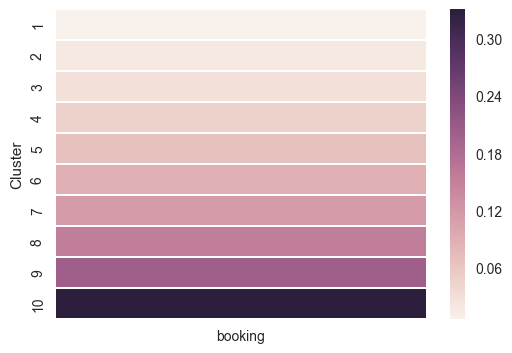

In [71]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.heatmap(RESUMO[['booking']], annot=False, linewidths=.5)    

In [72]:
RESUMO

,Qtd_meses_P_renovacoes,fl_GerenteConta,quantidade_renovacoes_prov,fl_Dev,nr_PrecoMensal,Provisioning,idade_prov,Prob_Consumo,FlagChurn,idade_cli,fl_ServicoPai,booking
Cluster,,,,,,,,,,,,
1,0.121689,0.000000,0.128805,0.000353,0.969465,113350,0.652514,0.176263,0.000000,2.534848,0.029828,0.007622
2,5.102744,0.000350,3.315390,0.021088,46.208400,59940,20.775676,0.415087,0.000017,41.303629,1.204021,0.017901
3,3.823878,0.001377,6.004263,0.040507,64.976118,44313,13.948975,0.462865,0.147564,43.829234,1.306163,0.030036
4,5.480934,0.001488,2.952614,0.044653,74.882949,35608,13.905714,0.546399,0.266485,36.402015,1.650809,0.048304
5,4.286558,0.007701,7.328947,0.113389,130.492184,25320,16.969744,0.607496,0.651422,54.576565,2.240047,0.068562
6,4.073215,0.023107,6.769414,0.281983,228.497455,16618,16.140325,0.669359,1.126128,60.263003,3.314960,0.091948
7,4.447367,0.098157,5.654228,0.662349,390.220296,9495,14.952038,0.727942,2.209584,65.330938,5.401053,0.116272
8,4.220484,0.221881,5.876240,0.892219,484.625750,5539,13.671171,0.775068,1.908467,66.130779,5.384004,0.156888
9,4.373780,0.874882,5.205163,2.183254,865.359039,3165,13.776887,0.813302,3.675197,74.553199,8.841390,0.203160


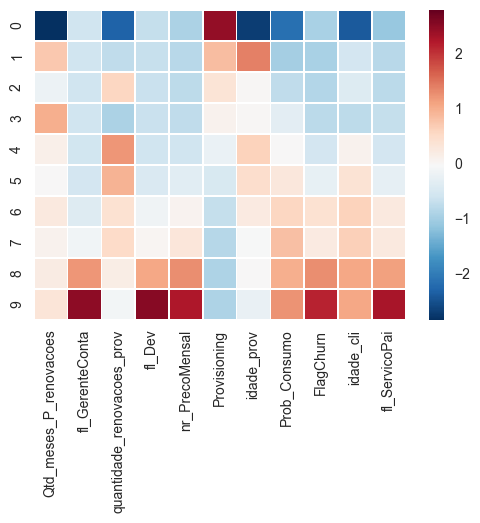

In [73]:
RESUMO.drop('booking', axis = 1, inplace=  True)
colunas = RESUMO.columns
RESUMO = scaler.fit_transform(RESUMO)
RESUMO = pd.DataFrame(data=RESUMO)
RESUMO.columns = colunas
RESUMO
sns.heatmap(RESUMO, annot=False, linewidths=.5)    

In [91]:
colunas = list()
for i in df_treino.columns: 
    if i[:8] == 'Servico_':
        colunas.append(i)

In [96]:
dict_colunas = {str(i): 'mean' for i in colunas}
RESUMO = df_treino.groupby('Cluster').agg(dict_colunas)

In [98]:
RESUMO.T

Cluster,1,2,3,4,5,6,7,8,9,10
Servico_Registro Dominio,0.574354,0.336119,0.451583,0.656706,0.950553,1.656938,3.440126,3.027622,6.019589,9.829754
Servico_Google Apps,0.001120,0.000417,0.004197,0.003230,0.005213,0.006258,0.009163,0.012457,0.008215,0.026216
Servico_Licencas - Cloud,0.003855,0.000200,0.000429,0.000309,0.000869,0.003671,0.009900,0.022387,0.036967,0.072647
Servico_Email MKT,0.134892,0.007925,0.067226,0.034683,0.180174,0.309424,0.331543,0.473190,0.490995,0.577701
Servico_Cloud Server Pro,0.121235,0.002936,0.014668,0.013143,0.044155,0.142255,0.306372,0.601553,1.061927,1.455148
Servico_WR,0.012607,0.006657,0.020603,0.010251,0.031003,0.042604,0.048868,0.062286,0.075513,0.126658
Servico_Cloud VPS,0.008187,0.000884,0.011419,0.003960,0.006754,0.011253,0.016640,0.021484,0.025276,0.075490
Servico_Hospedagem,0.558571,0.787671,0.624896,0.749045,0.801303,1.000842,1.189995,1.322802,1.646761,2.015477
Servico_SSL,0.000168,0.000033,0.000045,0.000899,0.013586,0.007101,0.023381,0.029067,0.030016,0.085281
Servico_Email,0.047993,0.068302,0.072575,0.103207,0.142180,0.176676,0.226435,0.259975,0.351027,0.387555


# Aplicando na Base

In [35]:
fim_janela_feature = df_base.Instalacao.max()
inicio_janela_churn = fim_janela_feature
aux_janela_feature = fim_janela_feature+ relativedelta(months=-12)

In [36]:
df_treino = df_base[(df_base.Instalacao_AnoMes < fim_janela_feature)].copy()

In [37]:
grade = pd.date_range(start=aux_janela_feature, end=df_treino.Instalacao_AnoMes.max(), freq='MS', normalize=True)

In [38]:
agg_dict = {'nr_PrecoMensal' : 'sum'}
df_historico_valor = df_treino[(df_treino.nr_PrecoMensal> 0) & (df_treino.Instalacao_AnoMes >= aux_janela_feature)].groupby(['cd_ChaveCliente', 'Instalacao_AnoMes']).agg(agg_dict)
novo_indice = [(x, y) for x in df_historico_valor.index.levels[0] for y in grade]
novo_indice = pd.MultiIndex.from_tuples(novo_indice, names=df_historico_valor.index.names)
df_historico_valor = df_historico_valor.reindex(novo_indice, fill_value=0)
df_historico_valor = df_historico_valor.unstack(level=-1)
df_historico_valor.columns = df_historico_valor.columns.droplevel()
colunas = ['vlr_m-1','vlr_m-2','vlr_m-3','vlr_m-4','vlr_m-5','vlr_m-6','vlr_m-7','vlr_m-8','vlr_m-9','vlr_m-10','vlr_m-11','vlr_m-12'] 
df_historico_valor.columns = colunas
df_historico_valor['vlr_trim-1'] = [v1+v2+v3 for v1,v2,v3 in zip
                                    (df_historico_valor['vlr_m-1'], 
                                     df_historico_valor['vlr_m-2'],  
                                     df_historico_valor['vlr_m-3'])]
df_historico_valor['vlr_trim-2'] = [v1+v2+v3 for v1,v2,v3 in zip
                                    (df_historico_valor['vlr_m-4'], 
                                     df_historico_valor['vlr_m-5'],  
                                     df_historico_valor['vlr_m-6'])]
df_historico_valor['vlr_trim-3'] = [v1+v2+v3 for v1,v2,v3 in zip
                                    (df_historico_valor['vlr_m-7'], 
                                     df_historico_valor['vlr_m-8'],  
                                     df_historico_valor['vlr_m-9'])]
df_historico_valor['vlr_trim-4'] = [v1+v2+v3 for v1,v2,v3 in zip
                                    (df_historico_valor['vlr_m-10'], 
                                     df_historico_valor['vlr_m-11'],  
                                     df_historico_valor['vlr_m-12'])]
df_historico_valor['vlr_ano'] = [v1+v2+v3+v4 for v1,v2,v3,v4 in zip
                                    (df_historico_valor['vlr_trim-1'], 
                                     df_historico_valor['vlr_trim-2'],  
                                     df_historico_valor['vlr_trim-3'],
                                     df_historico_valor['vlr_trim-4'])]

In [39]:
agg_dict = {'Provisioning' : 'count'}
df_historico_qtd = df_treino[df_treino.Instalacao_AnoMes >= aux_janela_feature].groupby(['cd_ChaveCliente', 'Instalacao_AnoMes']).agg(agg_dict)
novo_indice = [(x, y) for x in df_historico_qtd.index.levels[0] for y in grade]
novo_indice = pd.MultiIndex.from_tuples(novo_indice, names=df_historico_qtd.index.names)
df_historico_qtd = df_historico_qtd.reindex(novo_indice, fill_value=0)
df_historico_qtd = df_historico_qtd.unstack(level=-1)
df_historico_qtd.columns = df_historico_qtd.columns.droplevel()
colunas_ts = [c for c in df_historico_qtd.columns if isinstance(c, pd.tslib.Timestamp)]
colunas = ['qtd_m-1','qtd_m-2','qtd_m-3','qtd_m-4','qtd_m-5','qtd_m-6',
           'qtd_m-7','qtd_m-8','qtd_m-9','qtd_m-10','qtd_m-11','qtd_m-12'] 
df_historico_qtd.columns = colunas
df_historico_qtd['qtd_trim-1'] = [q1+q2+q3 for q1,q2,q3 in zip
                                  (df_historico_qtd['qtd_m-1'],
                                   df_historico_qtd['qtd_m-2'],
                                   df_historico_qtd['qtd_m-3'])]
df_historico_qtd['qtd_trim-2'] = [q1+q2+q3 for q1,q2,q3 in zip
                                  (df_historico_qtd['qtd_m-4'], 
                                   df_historico_qtd['qtd_m-5'],  
                                   df_historico_qtd['qtd_m-6'])]
df_historico_qtd['qtd_trim-3'] = [q1+q2+q3 for q1,q2,q3 in zip
                                  (df_historico_qtd['qtd_m-7'], 
                                   df_historico_qtd['qtd_m-8'],  
                                   df_historico_qtd['qtd_m-9'])]
df_historico_qtd['qtd_trim-4'] = [q1+q2+q3 for q1,q2,q3 in zip
                                  (df_historico_qtd['qtd_m-10'], 
                                   df_historico_qtd['qtd_m-11'],  
                                   df_historico_qtd['qtd_m-12'])]
df_historico_qtd['qtd_ano'] = [v1+v2+v3+v4 for v1,v2,v3,v4 in zip
                               (df_historico_qtd['qtd_trim-1'], 
                                df_historico_qtd['qtd_trim-2'],  
                                df_historico_qtd['qtd_trim-3'],
                                df_historico_qtd['qtd_trim-4'])]

In [40]:
df_historico = pd.concat([df_historico_valor, df_historico_qtd], axis=1)

In [41]:
df_treino['Periodicidade_Meses'] = [periodicidade(x) for x in df_treino.ds_Periodicidade]
df_treino['idade_prov'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Instalacao_AnoMes]
df_treino['idade_cli'] = [diff_month(fim_janela_feature, Inst) for Inst in df_treino.Primeiro_Servico_LW_AnoMes]
df_treino['quantidade_renovacoes_prov'] = [int(id_prov/peri_mes) for 
                                           id_prov, peri_mes in zip (df_treino.idade_prov, df_treino.Periodicidade_Meses)]
df_treino['Qtd_meses_P_renovacoes'] = [peri_mes-(idade_prov-qtd_renov*peri_mes) for
                                       peri_mes,idade_prov,qtd_renov in 
                                       zip(df_treino.Periodicidade_Meses, 
                                           df_treino.idade_prov, 
                                           df_treino.quantidade_renovacoes_prov)]

In [42]:
df_treino = df_treino[~df_treino.Servico.isnull()].copy()
lista = list(df_treino.Servico.unique())
lista = ['Servico_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['Servico']
colunas = ['cd_ChaveCliente', 'Servico']
df_ohe_Servico = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_Servico = df_ohe_Servico.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_Servico.drop(df_ohe_Servico.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino = df_treino[~df_treino.ds_Periodicidade.isnull()].copy()
lista = list(df_treino.ds_Periodicidade.unique())
lista = ['ds_Periodicidade_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['ds_Periodicidade']
colunas = ['cd_ChaveCliente', 'ds_Periodicidade']
df_ohe_ds_Periodicidade = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_ds_Periodicidade = df_ohe_ds_Periodicidade.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_ds_Periodicidade.drop(df_ohe_ds_Periodicidade.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino = df_treino[~df_treino.Perfil.isnull()].copy()
lista = list(df_treino.Perfil.unique())
lista = ['Perfil_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['Perfil']
colunas = ['cd_ChaveCliente', 'Perfil']
df_ohe_Perfil = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_Perfil = df_ohe_Perfil.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_Perfil.drop(df_ohe_Perfil.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino = df_treino[~df_treino.classificacao.isnull()].copy()
lista = list(df_treino.classificacao.unique())
lista = ['classificacao_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['classificacao']
colunas = ['cd_ChaveCliente', 'classificacao']
df_ohe_classificacao = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_classificacao = df_ohe_classificacao.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_classificacao.drop(df_ohe_classificacao.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino = df_treino[~df_treino.Status.isnull()].copy()
lista = list(df_treino.Status.unique())
lista = ['Status_' + str(i) for i in lista]
dict_lista = {str(i): 'sum' for i in lista}
ohe = ['Status']
colunas = ['cd_ChaveCliente', 'Status']
df_ohe_Status = pd.get_dummies(df_treino[colunas], columns = ohe,)
df_ohe_Status = df_ohe_Status.groupby('cd_ChaveCliente').agg(dict_lista)
df_ohe_Status.drop(df_ohe_Status.columns[[0]], axis=1, inplace= True)
###################################################################################

###################################################################################
df_treino['idade_prov_sum'] = df_treino.idade_prov
df_treino['idade_cli_sum'] = df_treino.idade_cli
df_treino['quantidade_renovacoes_prov_sum'] = df_treino.quantidade_renovacoes_prov
df_treino['Qtd_meses_P_renovacoes_sum'] = df_treino.Qtd_meses_P_renovacoes
dict_lista = {'Provisioning' : 'count',
              'nr_PrecoMensal' : 'sum',
              'fl_ServicoPai' : 'sum',
              'fl_Dev' : 'sum',
              'Data_Desativacao_flag' : 'sum',
              'fl_GerenteConta' : 'sum',
              'idade_prov' : 'mean',
              'idade_cli' : 'mean',
              'quantidade_renovacoes_prov' : 'mean',
              'Qtd_meses_P_renovacoes' : 'mean',
              'idade_prov_sum' : 'sum',
              'idade_cli_sum' : 'sum',
              'quantidade_renovacoes_prov_sum' : 'sum',
              'Qtd_meses_P_renovacoes_sum' : 'sum',
              'FlagChurn' : 'sum'}
df_treino = df_treino.groupby('cd_ChaveCliente').agg(dict_lista)

###################################################################################
###################################################################################
df_treino = pd.concat([df_treino, df_ohe_Servico, 
                       df_ohe_ds_Periodicidade, df_ohe_Perfil, 
                       df_ohe_classificacao, df_ohe_Status], axis=1)

In [43]:
df_treino = pd.concat([df_treino, df_historico], axis=1)

In [44]:
df_treino.reset_index(inplace= True)

In [45]:
df_treino.rename(columns= {'index': 'cd_ChaveCliente'}, inplace= True)

In [46]:
percentiles= [10,20,30,40,50,60,70,80,90]
Perc = cria_curva(percentiles, df_treino.nr_PrecoMensal)
df_treino['nr_PrecoMensal_curva'] = [marca_base(Perc, x) for x in df_treino.nr_PrecoMensal]

D:\Users\felipe.santos\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [47]:
df_treino.fillna(0,inplace= True)

In [48]:
X = df_treino[Colunas_Modelo].copy()
X = scaler.fit_transform(X)

y_pred = clf.predict_proba(X)
y_pred = pd.DataFrame(data=y_pred[:,1])
y_pred.rename(columns= {0: 'Prob_Consumo'}, inplace= True)
y_pred.shape

df_treino = pd.concat([df_treino, y_pred], axis=1)

In [49]:
df_treino.sort_values(['Prob_Consumo'], ascending= 1 ,inplace=True)

In [50]:
df_treino.reset_index(inplace= True, drop= True)
df_treino.reset_index(inplace= True)

In [51]:
df_treino.rename(columns= {'index': 'aux_cluster'}, inplace= True)

In [52]:
lista = [round(aux_Cluster[aux_Cluster.index == 1].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 2].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 3].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 4].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 5].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 6].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 7].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 8].Perc.max()*df_treino.aux_cluster.max(),0),
         round(aux_Cluster[aux_Cluster.index == 9].Perc.max()*df_treino.aux_cluster.max(),0)]

In [53]:
lista[1] = lista[1] + lista[0]
lista[2] = lista[2] + lista[1]
lista[3] = lista[3] + lista[2]
lista[4] = lista[4] + lista[3]
lista[5] = lista[5] + lista[4]
lista[6] = lista[6] + lista[5]
lista[7] = lista[7] + lista[6]
lista[8] = lista[8] + lista[7]

In [54]:
lista

[116111.0,
 176695.0,
 223833.0,
 262550.0,
 292844.0,
 311357.0,
 322297.0,
 329029.0,
 332395.0]

In [55]:
df_treino['Cluster'] = [marca_base(lista, x) for x in df_treino.aux_cluster]

In [56]:
df_treino.Cluster.value_counts()

1     116111
2      60584
3      47138
4      38717
5      30294
6      18513
7      10940
8       6732
10      4208
9       3366
Name: Cluster, dtype: int64

In [57]:
dict_lista = {'Prob_Consumo' : 'mean',
              'Provisioning' : 'count',
              'nr_PrecoMensal' : 'mean',
              'fl_ServicoPai' : 'mean',
              'fl_Dev' : 'mean',
              'fl_GerenteConta' : 'mean',
              'idade_prov' : 'mean',
              'idade_cli' : 'mean',
              'quantidade_renovacoes_prov' : 'mean',
              'Qtd_meses_P_renovacoes' : 'mean',
              'FlagChurn' : 'mean'}

RESUMO = df_treino.groupby('Cluster').agg(dict_lista)
#NomeCSV = 'Prob_Consumo_ResumoBaseAtiva.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#RESUMO.to_csv(NomeCSV)
#RESUMO = pd.read_csv('./'+NomeCSV, error_bad_lines = False, sep=',')

In [58]:
RESUMO

,idade_cli,fl_ServicoPai,Prob_Consumo,idade_prov,FlagChurn,nr_PrecoMensal,quantidade_renovacoes_prov,Provisioning,fl_Dev,fl_GerenteConta,Qtd_meses_P_renovacoes
Cluster,,,,,,,,,,,
1,1.820405,0.043613,0.235261,0.976876,0.000000,1.227018,0.039436,116111,0.000732,0.000009,0.149736
2,38.886373,1.218490,0.435901,19.612455,0.000000,44.807555,2.535769,60584,0.018173,0.000264,5.649363
3,34.855714,1.402732,0.473061,16.013768,0.020684,60.832776,4.421500,47138,0.024736,0.000594,4.884626
4,45.388223,1.438231,0.528252,15.367905,0.287677,69.032041,5.993733,38717,0.043883,0.001240,5.229379
5,59.069789,2.126263,0.604971,20.161697,0.555391,128.520889,8.241099,30294,0.095200,0.005084,4.071797
6,63.267426,3.217253,0.672645,18.600722,1.002647,221.997561,7.758003,18513,0.248258,0.016205,4.004926
7,67.276752,4.476325,0.721707,17.104102,1.665905,340.194161,7.215333,10940,0.503108,0.074132,4.183503
8,74.281099,6.989602,0.766082,16.060864,2.839275,550.978060,6.532455,6732,1.105615,0.254456,4.123277
9,73.299334,7.237374,0.805853,14.688236,2.531491,732.488437,6.141924,3366,1.492276,0.461081,3.983623


In [ ]:
#NomeCSV = 'Prob_Consumo.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#df_treino[['Cluster','cd_ChaveCliente']].set_index(['Cluster']).to_csv(NomeCSV)

In [ ]:
#NomeCSV = '/home/felipe/Algoritmos_todosProdutos/BaseOriginal.'+str(fim_janela_feature.year)+'_'+str(fim_janela_feature.month)+'_'+str(fim_janela_feature.day)+'.csv'
#df_base.to_csv(NomeCSV)